In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import copy
import time

from PIL import Image

In [2]:
# Loading Data
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')

print(data_train.shape, labels_train.shape)

(270000, 3717) (3717,)


In [3]:
# Loading Unknown Class Data
data_unknown = np.load('data_unknown.npy')
labels_unknown = np.load('labels_unknown.npy')

print(data_unknown.shape, labels_unknown.shape)

(270000, 2000) (2000,)


In [4]:
data_train = np.concatenate((data_train, data_unknown),axis = 1)
labels_train = np.concatenate((labels_train, labels_unknown))
labels_train[labels_train == -1] = 10

In [5]:
str(int(labels_train[0]))

'6'

In [6]:
# Labels Integer Encoding

labels_names = ['Nike',
                'Adidas',
                'Ford',
                'Honda',
                'General Mills',
                'Unilever',
                "McDonald's",
                'KFC',
                'Gators',
                '3M',
                'Unknown']

In [7]:
corrected_labels_train = labels_train.copy()
changes = {
    0: [2400, 361, 2439, 1865, 2671, 893, 3625],
    1: [1288, 3033, 3037, 3599, 780, 3140, 3372],
    2: [1670, 673, 1995, 2804, 2769, 2714, 653],
    3: [2980, 2937, 603, 1819, 3704, 2025],
    4: [2665, 1649, 1777, 1563, 2986],
    5: [1587, 2750, 2763, 1917],
    6: [2015, 2388, 38, 401, 2818, 1875, 3675],
    7: [3154, 744, 452, 3283, 3412, 313],
    8: [556, 1213, 3253],
    9: [2940, 1314, 1108, 708, 3277, 728],
}
for new_label, indices_to_change in changes.items():
    for index in indices_to_change:
        corrected_labels_train[index] = new_label

In [8]:
# field names 
#fields = ['Name', 'Branch', 'Year', 'CGPA'] 
    
# data rows of csv file 
rows = []
for i in range(data_train.shape[1]):
    rows.append(["img"+str(i)+".png", str(int(corrected_labels_train[i]))])


In [9]:
class LogoDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = self.data[index].reshape(300, 300, 3)
        image = Image.fromarray(image)
        y_label = torch.tensor(int(self.labels[index]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)


In [10]:
# hyperparameters

in_channel = 3
num_classes = 11
learning_rate = 1e-4
batch_size = 32
num_epochs = 20

In [11]:
# Data Augmentation

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
data_train = data_train.T

In [13]:
data_train, data_val, labels_train, labels_val = train_test_split(
    data_train, corrected_labels_train, test_size=0.2, random_state=0
)
train_dataset = LogoDataset(data=data_train, labels=labels_train, transform=train_transforms)
val_dataset = LogoDataset(data=data_val, labels=labels_val, transform=val_transforms)

In [14]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Model
model = models.densenet121(pretrained = True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.to(device)

/home/jiamin.chen/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jiamin.chen/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = StepLR(optimizer, step_size=round(num_epochs/2), gamma=0.1)
# StepLR decays the learning rate by a factor (gamma) every few epochs (step_size)

In [18]:
# Early stopping
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

In [19]:
# Train network

start = time.time()

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        if data is None or targets is None:
            continue

        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)
        
        train_loss += loss.item()
        _, predicted = scores.max(1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets).sum().item()

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or Adam step
        optimizer.step()
        

    scheduler.step()
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct_train / total_train

    # Validate
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(val_loader):
            if data is None or targets is None:
                continue

            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward
            scores = model(data)
            loss = criterion(scores, targets)
            
            val_loss += loss.item()
            _, predicted = scores.max(1)
            total_val += targets.size(0)
            correct_val += predicted.eq(targets).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100. * correct_val / total_val

    # Append the losses and accuracies to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print train and validation losses and accuracies
    print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping: stopping training at epoch {epoch} due to no improvement in validation loss for {patience} epochs")
        break
        
end = time.time()
elapsed_time = end - start
print(f"Elapsed time: {elapsed_time} s")

Epoch 0: Train Loss = 0.5862, Train Accuracy = 84.96%, Validation Loss = 0.1697, Validation Accuracy = 95.89%
Epoch 1: Train Loss = 0.1373, Train Accuracy = 97.11%, Validation Loss = 0.1143, Validation Accuracy = 96.94%
Epoch 2: Train Loss = 0.0613, Train Accuracy = 98.93%, Validation Loss = 0.1036, Validation Accuracy = 97.20%
Epoch 3: Train Loss = 0.0390, Train Accuracy = 99.10%, Validation Loss = 0.0861, Validation Accuracy = 97.47%
Epoch 4: Train Loss = 0.0326, Train Accuracy = 99.37%, Validation Loss = 0.0896, Validation Accuracy = 97.55%
Epoch 5: Train Loss = 0.0287, Train Accuracy = 99.39%, Validation Loss = 0.0894, Validation Accuracy = 97.81%
Epoch 6: Train Loss = 0.0172, Train Accuracy = 99.72%, Validation Loss = 0.0729, Validation Accuracy = 97.99%
Epoch 7: Train Loss = 0.0127, Train Accuracy = 99.80%, Validation Loss = 0.1024, Validation Accuracy = 97.12%
Epoch 8: Train Loss = 0.0151, Train Accuracy = 99.76%, Validation Loss = 0.0937, Validation Accuracy = 97.55%
Epoch 9: T

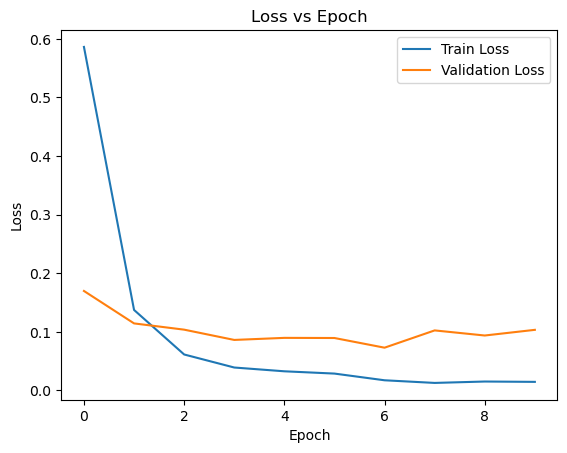

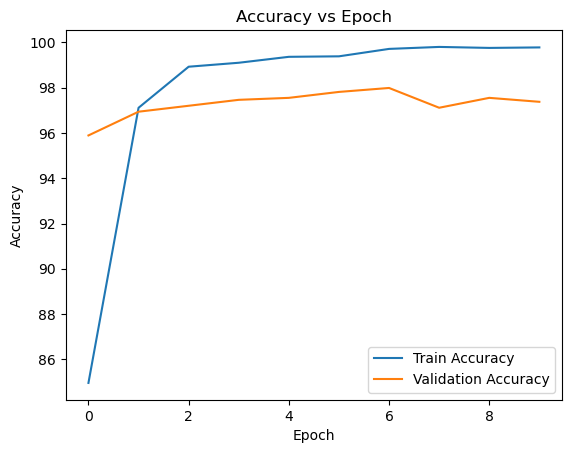

In [20]:
# Loss plot
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.show()

# Accuracy plot
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.show()